In [1]:
import kmapper as km
from kmapper.plotlyviz import *
import sklearn
#from sklearn import ensemble
# DBSCAN from sklearn for clustering algorithms
from sklearn.cluster import DBSCAN
# PCA from sklearn for projection/lens creation
from sklearn.decomposition import PCA
# from sklearn.manifold import MDS

# scipy for interpolation
# import scipy 
# from scipy.interpolate import *
# Plotly and Dash
import plotly.graph_objs as go
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
from ipywidgets import (HBox, VBox)
import dash_html_components as html
import dash_core_components as dcc
import dash
from ipywidgets import interactive, HBox, VBox, widgets, interact
import warnings
import pandas as pd
import json
import queue
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats
warnings.filterwarnings("ignore")

In [9]:
def generate_scomplex(df, epsilon = 1, min_samples = 10, n_cubes = [125,125], perc_overlap = [.4,.4]):

    X = RobustScaler().fit_transform(df)
    cluster_alg = sklearn.cluster.DBSCAN(eps = epsilon, min_samples = min_samples, metric = 'euclidean')
    pca = PCA(n_components = 2)
    lens = pca.fit_transform(X)
    print("Explained Variance: ", pca.explained_variance_ratio_)

    mapper = km.KeplerMapper(verbose = 0)
    scomplex = mapper.map(lens, X, cover = km.Cover(n_cubes = n_cubes, perc_overlap = perc_overlap), 
                                                clusterer = cluster_alg, remove_duplicate_nodes = True)  
    return scomplex


def visualize_by_state(scomplex, df, filepath):
    mapper = km.KeplerMapper(verbose = 0)
    continuous_variables =  ["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]
    var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
    projected_var_indices = [var_to_index[var] for var in continuous_variables]
    summary_variable = mapper.project(np.array(df), projection = projected_var_indices, scaler = None)
    
    # Make HTML with color values as the states
    color_vals = df[scomplex['maxima']]
    color_names = scomplex['maxima']
    kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                        color_values = color_vals,
                                                                        color_function_name = color_names)

    #for node in kmgraph['nodes']:
    #    node['custom_tooltips'] = np.array(water_df[variable])[scomplex['nodes'][node['name']]]

    plotly_graph_data = plotly_graph(kmgraph, graph_layout = 'fr', factor_size = 2.5, edge_linewidth = 0.5)

    layout = plot_layout(title = 'LTRM DATA',  
                        width = 620, height = 570,
                        annotation_text = get_kmgraph_meta(mapper_summary))

#     # FigureWidget is responsible for event listeners
#     fw_graph = go.FigureWidget(data = plotly_graph_data, layout = layout)
#     fw_hist = node_hist_fig(colorf_distribution)
#     fw_summary = summary_fig(mapper_summary, height = 300)
#     dashboard = hovering_widgets(kmgraph, 
#                                 fw_graph, 
#                                 ctooltips = True,
#                                 member_textbox_width = 600)
    
    #Update the fw_graph colorbar, setting its title:
    #fw_graph.data[1].marker.colorbar.title = 'hi'

    html_output_path = filepath

    mapper.visualize(scomplex, color_values = color_vals, color_function_name = color_names, 
                    path_html = html_output_path, lens = summary_variable, lens_names = continuous_variables)


def k_nearest_neighbors(df, neigh, point, k):
    return neigh.kneighbors([list(df.loc[point])], k)[0].flatten()
    
def calculate_density(scomplex, node, df, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df)
    knn = 0
    n = len(scomplex['nodes'][node])
    for point in scomplex['nodes'][node]:
        distances = k_nearest_neighbors(df, neigh, point, k)
        knn += (sum(distances) / k)
    density = knn / (n*n)
    return (1.0 / density)

def generate_graph(scomplex, shape):
    dg = generate_nodes(scomplex, shape)
    dg = generate_edges(scomplex, shape, dg)
    return dg

def generate_nodes(scomplex, shape):
    dg = nx.DiGraph()
    dg.add_nodes_from(shape)
    return dg

def generate_edges(scomplex, shape, dg):
    for node in shape:
        if node in scomplex['links']:
            for adjacent_node in scomplex['links'][node]:
                if scomplex['density'][node] < scomplex['density'][adjacent_node]:
                    dg.add_edge(node, adjacent_node)
                else:
                    dg.add_edge(adjacent_node, node)
    return dg

def get_local_maxima(dg):
    maxima = []
    for node in list(dg.nodes):
        succ = dict(nx.bfs_successors(dg, source=node))
        if not succ[node]:
            maxima.append(node)
    return maxima

def draw_graph(scomplex, filepath, with_labels=False):
    #colors = ['#ff0000', '#3366ff', '#0BB30B', '#A312A3', '#669999']
    colors = ['#ff0000', '#3366ff', '#0BB30B', '#A312A3', '#669999', '#4B8F8C', '#484DD6', '#2C365E', '#C5979D']
    colors.reverse()
    colors_dict = {scomplex['maxima'][i] : colors[i] for i in range(len(scomplex['maxima']))}
    transition_color = '#D8D135'
    color_map = []
    scomplex['states'] = {scomplex['maxima'][i] : [] for i in range(len(scomplex['maxima']))}
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    #ax.set_title('Mississippi River Ecological States', fontsize=40)
    
    transition_exists = False
    for node in scomplex['graph']:
        distDict = {scomplex['maxima'][i] : graph_distance(scomplex['graph'], node, scomplex['maxima'][i])
                    for i in range(len(scomplex['maxima']))}
        minDist = min(distDict.values())
        states = [maxima if distDict[maxima] == minDist else None for maxima in scomplex['maxima']]
        states = list(filter(None, states))
        
        for state in states:
            scomplex['states'][state].append(node)
        
        if len(states) > 1:
            color_map.append(transition_color)
            transition_exists = True
        else:
            color_map.append(colors_dict[states[0]])
    
    #making the legend
    for node in scomplex['maxima']:
        plt.scatter([],[], c=[colors_dict[node]], label = "La Grange State " + str(scomplex['maxima'].index(node) + 1))
    if transition_exists:
        plt.scatter([],[], c=[transition_color], label = "Transition State")
    plt.legend(markerscale = 3, prop={"size":14})
        
    #scomplex['graph'] = nx.relabel_nodes(scomplex['graph'], relabeling, copy=False)
    nx.draw_kamada_kawai(scomplex['graph'], with_labels=with_labels, node_color=color_map, node_size = 200)
    plt.tight_layout()
    plt.savefig(filepath, format="PNG")
    plt.show()

def graph_distance(dg, source, target):
    if nx.has_path(dg, source, target):
        return len(nx.shortest_path(dg, source, target))
    return float('inf')


def getSubdf(scomplex, shape, df):
    """
    Returns the part of the data frame from the particular shape in the simplicial complex.
    params:
    scomplex: the entire simplicial complex
    shape: the particular shape being inspected (within the simplicial complex)
    df: the entire data frame
    
    Description:
    1. Get all the nodes from the particular simplicial complex. 
    2. Generate the indices we care about from the particular shape. To do this, we read each node and append it's 
    indices to a list. Then, we convert the list to a set and then back to a list to eliminate duplicates.
    3. Return the dataframe with only those indices.
    """
    nodes = scomplex.get('nodes')
    indices = []
    npShape = np.array(shape).flatten()
    for node in npShape:
        indices.append(nodes.get(node))
    indices = list(set([item for sublist in indices for item in sublist]))
    subdf = df.loc[indices]
    return subdf


def adjacent(v, scomplex):
    """
    Determines the nodes adjacent to a given vertex
    
    params:
    v: vertex
    scomlex: the entire simplicial complex
    
    Description:
    Determines the nodes that are adjacent to a given vertex.
    """
    
    simplices = scomplex.get('simplices')
    edges = [item for item in simplices if len(item) == 2]
    result = []
    for edge in edges:
        if v in edge:
            for item in edge:
                if item != v:
                    result.append(item)
    return result


def bfs(node, scomplex):
    """
    Conducts a breadth first search to obtain the entire shape from a given node
    params:
    node: the start node
    scomplex: the entire simplicial complex
    
    Description:
    Preforms a breadth first search to obtain the entire shape for a given start node.
    """
    Q = queue.Queue()
    result = []
    result.append(node)
    Q.put(node)
    while not Q.empty():
        v = Q.get()
        adjacentEdges = adjacent(v, scomplex)
        for edge in adjacentEdges:
            if edge not in result:
                result.append(edge)
                Q.put(edge)
    return result


def condenseShape(shape, scomplex):
    """
    
    params:
    shape: a shape of two nodes. must be 2
    scomplex: the entire simplicial complex
    
    description:
    gets the two nodes a and b
    gets the indices for a and b (what is inside the nodes)
    if a \subseteq b, return b
    elif b \subseteq a, return a 
    else return shape 
    
    """
    nodes = scomplex.get('nodes')
    a = shape[0]
    b = shape[1]
    aIndices = set(nodes.get(a))
    bIndices = set(nodes.get(b))
    
    if aIndices.issubset(bIndices):
        return b
    elif bIndices.issubset(aIndices):
        return a
    else:
        return shape


def getShapes(scomplex):
    """
    Gets all of the shapes from a given simplicial complex.
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Obtain all the nodes for the entire complex
    2. For each node, preform a breadth first search to obtain everything in that particular shape. 
    If this entire shape has not already been discovered, add it to the set of results. 
    The result item is a set as the order of the shapes does not matter. The resulting shape is a frozenset
    which means items cannot be added or removed once created, and is needed to allow the set object to have other sets within it.
    3. Convert each shape to a list and the result to a list for easier navigation outside of the function.
    4. Return the result
    
    """
    
    nodes = list(scomplex.get('nodes').keys())
    result = set()
    for node in nodes: # currently does more computations than necessary due to going through every node without considering it is already in a shape
        bfsResult = frozenset(bfs(node, scomplex))
        result.add(bfsResult)
    result = [list(x) for x in result]
    # Sort the list depending on what is decided: nodes or indices. Currently doing it by number of nodes
    result.sort(key = len, reverse = True)
    
    return result

def clean_getShapes(scomplex):
    """
    Condenses 1-simplices down to 0-simplices when each node 
    is a subset of the other 
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Get all the shapes from the original getShapes function
    2. For shapes that of length 2, if one is a subset of the other, return the larger of the two
        Otherwise, do nothing
    3. return the clean Shapes list 
    
    """
    shapes = getShapes(scomplex)
    cleanShapes = []
    for shape in shapes:
        if len(shape) == 2:
            shape = condenseShape(shape, scomplex)
            cleanShapes.append([shape])
        else:
            cleanShapes.append(shape)
    return cleanShapes


def append_states(scomplex, shape, df):
    for maximum in scomplex['maxima']:
        entries = [0 for x in range(df.shape[0])]
        for node in scomplex['states'][maximum]:
            for entry in scomplex['nodes'][node]:
                entries[entry] = 1
        df[maximum] = entries

In [7]:
df = pd.read_csv(r"C:\Users\killiad\Documents\Senior\REU\Data\water_full.csv")
continuous_variables = ["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]
df = df[df['FLDNUM']=='Havana, IL']
df_years = df.copy()
df = df[continuous_variables]
df.reset_index(drop = True, inplace = True)
df_years.reset_index(drop = True, inplace = True)
stratum = {'Main channel' : 1, 'Side channel' : 2, 'Backwater area contiguous to the main channel' : 3}
df_years = df_years.replace({"STRATUM" : stratum})
k = int(df.shape[0] / 10) + 1

epsilons = {'River' : 1.2, 'LaGrange' : 1.75, 'Doug' : 2.3}
cubes = {'River' : [125,125], 'LaGrange' : [88,38]}

scomplex = generate_scomplex(df, epsilon = epsilons['LaGrange'],
                             min_samples = 20, n_cubes = cubes['LaGrange'], perc_overlap = [0.40,0.40])
scomplex['density'] = {}
largestShape = clean_getShapes(scomplex)[0]
print("Number of Nodes in Largest Shape: ", len(largestShape))
i = 1
X = pd.DataFrame(RobustScaler().fit_transform(df))
for node in largestShape:
    print(i)
    i += 1
    scomplex['density'][node] = calculate_density(scomplex, node, X, k)

Explained Variance:  [0.44654951 0.18992681]
Number of Nodes in Largest Shape:  125
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125


Number of Maxima:  2


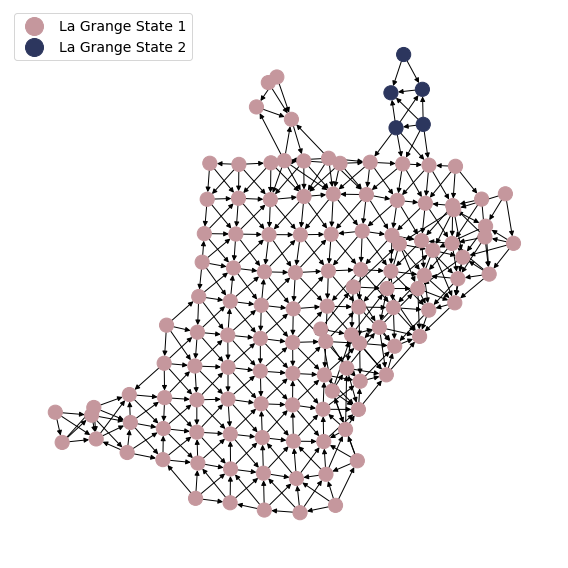

In [10]:
scomplex['graph'] = generate_graph(scomplex, largestShape)
scomplex['maxima'] = get_local_maxima(scomplex['graph'])
print("Number of Maxima: ", len(scomplex['maxima']))
filepath =  r"C:\Users\killiad\Documents\Senior\REU\Mapper\LaGrange\States.png"
draw_graph(scomplex, filepath, with_labels=False)

In [ ]:
filepath = r"C:\Users\killiad\Documents\Senior\REU\Mapper\LaGrange\States.html"
append_states(scomplex, largestShape, df)
visualize_by_state(scomplex, df, filepath)

In [ ]:
shape_df = getSubdf(scomplex, largestShape, df)
shape_df.shape[0] / df.shape[0]

In [ ]:
df['cube49_cluster0'].sum()

In [ ]:
df['cube42_cluster0'].sum()

In [ ]:
state1 = df[df['cube49_cluster0']==1]
state2 = df[df['cube42_cluster0']==1]

In [ ]:
state1['SS'].describe()

In [ ]:
state2['SS'].describe()

In [ ]:
continuous_variables = ["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]
for var in continuous_variables:
    print(var + ': ', stats.ttest_ind(state1[var], state2[var], equal_var = False).pvalue)

In [ ]:
year_state1 = df_years[df['cube49_cluster0']==1]
year_state2 = df_years[df['cube42_cluster0']==1]
year_state1.hist('YEAR', bins = 25)

In [ ]:
year_state2.hist('YEAR', bins = 25)

In [ ]:
year_state1[year_state1['YEAR'].isin([1995,1996,1997,1998])].shape[0] / df['cube49_cluster0'].sum()